# Project - 2


`Libraries`


In [14]:
import matplotlib.pyplot as plt
import sys
import numpy as np

`Grid Specifications`


In [15]:
Lx, Ly = 50.0, 1.0
Re = 1e4
U_inf = 50.0
nx, ny = 1000, 250
nu = U_inf/(Re * Lx)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
psi = np.zeros((nx, ny))
tol = 1e-6

`Plotting Functions`


In [16]:
def contourPlot(x,y,u):
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, u.T, levels=50, cmap='jet')
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contour Plot of u')
    plt.show()

In [17]:
def streamlines(x,y,u,v):
    plt.streamplot(x, y, u.T, v.T, color='k', linewidth=1)
    plt.title('Streamlines Over Flat Plate')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

1. Euler Explicit scheme


In [18]:
dy = Ly / (ny - 1)
dx = (dy**2)/(2 *nu)

# Boundary conditions
u[:, -1] = U_inf
u[:, 0] = 0
v[:, 0] = 0

`Explicit parameters`


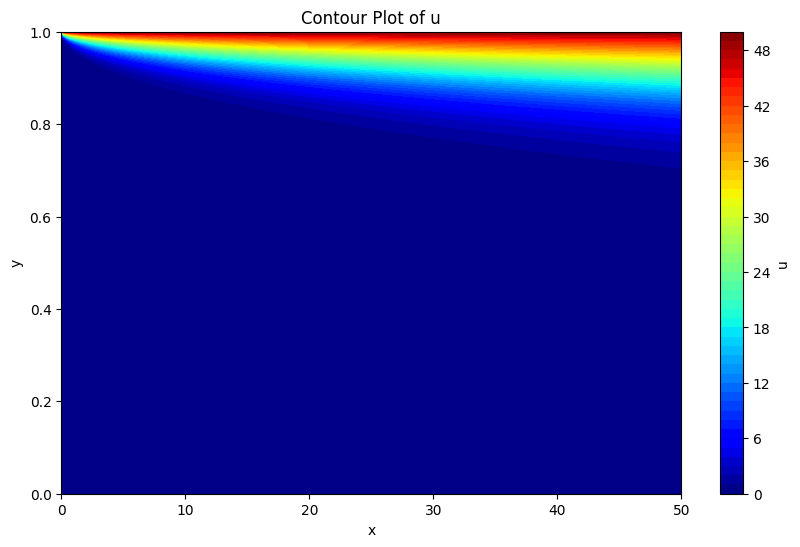

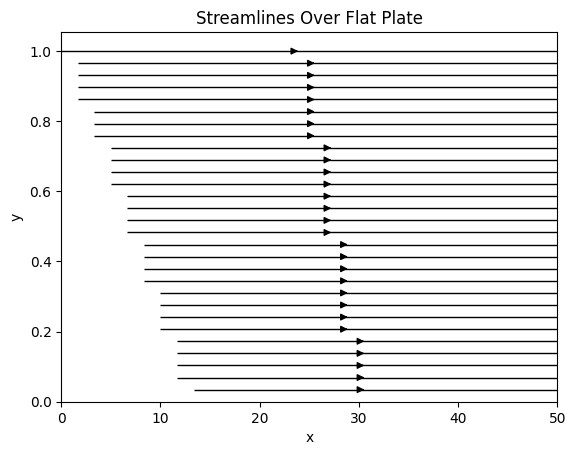

In [19]:
for i in range(1, nx):
    un = u[i-1, :].copy()

    for j in range(1, ny-1):
        v[i, j] = v[i, j-1] - (dy / (2 * dx)) * (u[i-1, j] - un[j])

        u[i, j] = un[j] + dx * (
            -v[i, j] * (un[j+1] - un[j-1]) / (2 * dy)
            + nu * (un[j+1] - 2 * un[j] + un[j-1]) / dy**2
        )

for i in range(1, nx):
    for j in range(1, ny):
        psi[i, j] = psi[i-1, j] - v[i, j] * dx

contourPlot(x,y,u)
streamlines(x,y,u,v)


C:\Users\Vardan\AppData\Local\Temp\ipykernel_7216\1189695827.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  eta[i, j] = y[j] * np.sqrt(1 / (nu * x[i]))
C:\Users\Vardan\AppData\Local\Temp\ipykernel_7216\1189695827.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  eta[i, j] = y[j] * np.sqrt(1 / (nu * x[i]))


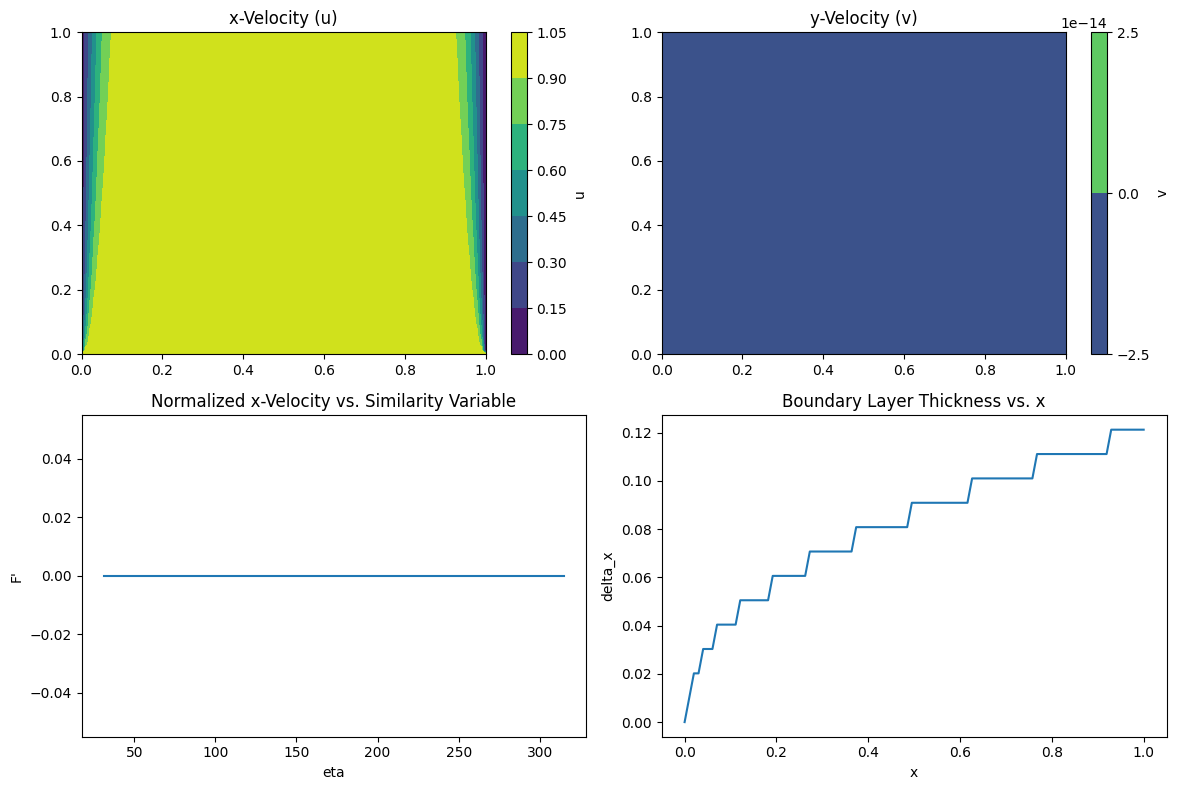

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid parameters
nx = 100
ny = 100
dx = 1 / (nx - 1)
dy = 1 / (ny - 1)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)

# Define boundary conditions
u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
psi = np.zeros((nx, ny))

# Set boundary conditions
u[0, :] = 1  # Inflow velocity
v[:, 0] = 0  # No-slip condition at the bottom wall
v[:, ny-1] = 0  # No-slip condition at the top wall

# Define Reynolds number
Re = 1000

# Define physical parameters
nu = 1 / Re

# Compute velocity fields
for i in range(1, nx):
    un = u[i-1, :].copy()

    for j in range(1, ny-1):
        v[i, j] = v[i, j-1] - (dy / (2 * dx)) * (u[i-1, j] - un[j])
        u[i, j] = un[j] + dx * (
            -v[i, j] * (un[j+1] - un[j-1]) / (2 * dy)
            + nu * (un[j+1] - 2 * un[j] + un[j-1]) / dy**2
        )


# Compute x-velocity (u) and y-velocity (v) fields
u_fields = u.copy()
v_fields = v.copy()

# Compute normalized x-velocity (F') and similarity variable (eta)
F_prime = np.zeros((nx, ny))
eta = np.zeros((nx, ny))
for i in range(nx):
    for j in range(ny):
        F_prime[i, j] = u[i, j] / 1  # Assuming U_infinity = 1
        eta[i, j] = y[j] * np.sqrt(1 / (nu * x[i]))

# Compute boundary layer thickness
delta_x = np.zeros(nx)
for i in range(nx):
    for j in range(ny):
        if u[i, j] >= 0.99 * 1:  # Assuming U_infinity = 1
            delta_x[i] = y[j]
            break

# Plot results
plt.figure(figsize=(12, 8))

# Contour plots of u and v
plt.subplot(2, 2, 1)
plt.contourf(x, y, u_fields)
plt.colorbar(label='u')
plt.title('x-Velocity (u)')

plt.subplot(2, 2, 2)
plt.contourf(x, y, v_fields)
plt.colorbar(label='v')
plt.title('y-Velocity (v)')

# Line plot of F' vs. eta
plt.subplot(2, 2, 3)
plt.plot(eta[:, ny-1], F_prime[:, ny-1])
plt.xlabel('eta')
plt.ylabel('F\'')
plt.title('Normalized x-Velocity vs. Similarity Variable')

# Line plot of boundary layer thickness vs. x
plt.subplot(2, 2, 4)
plt.plot(x, delta_x)
plt.xlabel('x')
plt.ylabel('delta_x')
plt.title('Boundary Layer Thickness vs. x')

plt.tight_layout()
plt.show()

2.  Euler Implicit scheme


3. Crank-Nicolson scheme
